In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.stats import beta 

# Bayesian A/B testing vs Frequentist A/B testing

Bayesian and frequentist A/B testing offer different approaches to making decisions and interpreting experiment results. This notebook will simulate the results of a hypothetical experiment and discuss how the results would be processed differently in Bayesian and frequentist frameworks

**Step 1: Define the experiment**

Let's say that we have implemented a new feature on a health insurance website with the goal of helping users more easily sign up for coverage. We want to assess differences in conversion rate for our new website design versus our old design to help decide which version to run with in the future 

In [3]:
#define parameters for beta function
beta_a,beta_b=[1.1]*beta.numargs
rv=beta(beta_a,beta_b)

In [4]:
#produce an array with 100 values equally spaced between the 1% and 99% quantiles of the chosen Beta distribution
x=np.linspace(0,1,100)

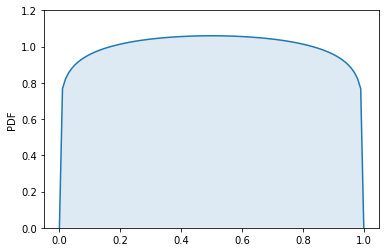

In [5]:
plt.figure()
plt.plot(x,rv.pdf(x))
plt.ylim(0,1.2)
plt.ylabel('PDF')
plt.fill_between(x,[0]*len(x),rv.pdf(x),alpha=.15)

In [6]:
#function to simulate conversion event

def simulate_conversion(base,effect_size,treatment):
    random_num=random.random()
    
    if treatment==True:
        if random_num<max(base+effect_size,0):
            return 1
        else:
            return 0
    else:
        if random_num<max(base,0):
            return 1
        else:
            return 0

In [7]:
def simulate_experiment(num_observations,base,effect_size,treatment):
    conversions=0
    for i in range(num_observations):
        conversions+=simulate_conversion(base,effect_size,treatment)
    return conversions

def simulate_experiments(num_experiments,num_observations,base,effect_size,treatment):
    exp_results=[0]*num_experiments
    for i in range(num_experiments):
        exp_results[i]=simulate_experiment(num_observations,base,effect_size,treatment)
    return exp_results

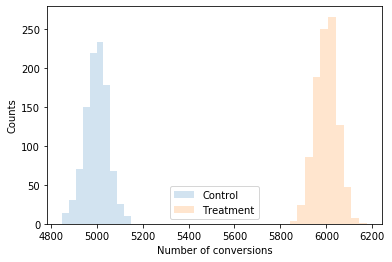

In [8]:
plt.figure()
treatment_effect=.1
base_effect=.5
plt.hist(simulate_experiments(1000,10000,base_effect,treatment_effect,False),label='Control',alpha=.2)
plt.hist(simulate_experiments(1000,10000,base_effect,treatment_effect,True),label='Treatment',alpha=.2)
plt.xlabel('Number of conversions')
plt.ylabel('Counts')
plt.legend()

In [183]:
class beta_distribution:
    def __init__ (self,beta_a=1,beta_b=1):
        self.beta_a=beta_a
        self.beta_b=beta_b
        self.rv=beta(beta_a,beta_b)
    
    def update_prior(self,base,effect_size,treatment):
        
        exp_result=simulate_conversion(base,effect_size,treatment)
        
        if exp_result==1:
            self.beta_a+=1
        else:
            self.beta_b+=1
        
        self.rv=beta(self.beta_a,self.beta_b)
        
        return exp_result
    
    def gen_pdf_array(self,X):
        return self.rv.pdf(X)

In [10]:
control_beta=beta_distribution(1,1)
variant_beta=beta_distribution(1,1)

In [11]:
num_trials=1000
for i in range(num_trials):
    control_beta.update_prior(base_effect,treatment_effect,False)
    variant_beta.update_prior(base_effect,treatment_effect,True)

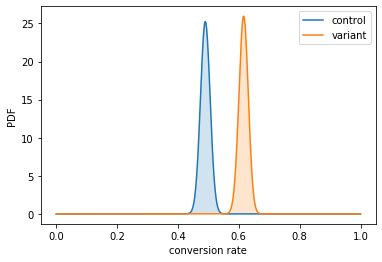

In [12]:
plt.figure()

x_vals=np.linspace(0,1,1000)
plt.plot(x_vals,control_beta.gen_pdf_array(x_vals),label='control')
plt.fill_between(x_vals,[0]*len(x_vals),control_beta.gen_pdf_array(x_vals),alpha=.2)
plt.plot(x_vals,variant_beta.gen_pdf_array(x_vals),label='variant')
plt.fill_between(x_vals,[0]*len(x_vals),variant_beta.gen_pdf_array(x_vals),alpha=.2)
plt.ylabel('PDF')
plt.xlabel('conversion rate')
plt.legend()

In [237]:
import scipy.integrate as integrate
    
class Experiment:
    def __init__ (self,treatment_effect=0,base_effect=.5,tolerance=.005):
        self.base=beta_distribution(1,1)
        self.variant=beta_distribution(1,1)
        self.treatment_effect=treatment_effect
        self.base_effect=base_effect  
        self.treatment_losses=[1]
        self.control_losses=[1]
        self.tolerance=tolerance
        self.num_steps=0
        self.base_events=[]
        self.treatment_events=[]
        
    def run_iteration(self):
        rand_val=random.random()
        if rand_val<.5:
            self.base.update_prior(self.base_effect,self.treatment_effect,False)
        else:
            self.variant.update_prior(self.base_effect,self.treatment_effect,True)
            
        self.compute_expected_loss()
        self.num_steps+=1

        return None
    
    def declare_winner(self):
        
        while (self.treatment_losses[-1]>self.tolerance and self.control_losses[-1]>self.tolerance) or self.num_steps>10000:
            rand_val=random.random()
            if rand_val<.5:
                test_result=self.base.update_prior(self.base_effect,self.treatment_effect,False)
                self.base_events.append(test_result)
            else:
                test_result=self.variant.update_prior(self.base_effect,self.treatment_effect,True)
                self.treatment_events.append(test_result)
                
            if self.num_steps>1000 and self.num_steps%100==0:
                
                self.compute_expected_loss()
                
                if self.treatment_losses[-1]<self.tolerance:
                    
                    return 1,self.num_steps
                
                else:
                    
                    return 0,self.num_steps


            self.num_steps+=1
            
        return None
            
    def plot_pdf(self):
        x_vals=np.linspace(0,1,1000)
        plt.plot(x_vals,self.base.gen_pdf_array(x_vals),label='control')
        plt.fill_between(x_vals,[0]*len(x_vals),self.base.gen_pdf_array(x_vals),alpha=.2)
        plt.plot(x_vals,self.variant.gen_pdf_array(x_vals),label='variant')
        plt.fill_between(x_vals,[0]*len(x_vals),self.variant.gen_pdf_array(x_vals),alpha=.2)
        plt.ylabel('PDF')
        plt.xlabel('conversion rate')
        plt.legend()
        plt.show()

    
    def compute_expected_loss(self):
        
        num_steps=1000
        x_vals=np.linspace(0,1,num_steps)
        base_pdf=self.base.gen_pdf_array(x_vals)
        exp_pdf=self.variant.gen_pdf_array(x_vals)
        
        treatment_loss=np.array([[base_pdf[i]*exp_pdf[j]*max(x_vals[i]-x_vals[j],0) for j in range(len(x_vals))] for i in range(len(x_vals))])
        control_loss=np.array([[base_pdf[i]*exp_pdf[j]*max(x_vals[j]-x_vals[i],0) for j in range(len(x_vals))] for i in range(len(x_vals))])
        
        self.treatment_losses.append((1/num_steps)**2*np.sum(treatment_loss))
        self.control_losses.append((1/num_steps)**2*np.sum(control_loss))
        
        return None
        
        

In [14]:
conversion_experiment=Experiment(.1,.5)

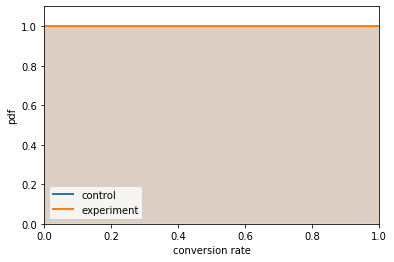

In [72]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 1))
x_vals=np.linspace(0,1,1000)
ax.set_ylim(bottom=0,top=1.1)
ax.set_xlabel('conversion rate')
ax.set_ylabel('pdf')
control_beta=beta_distribution()
experiment_beta=beta_distribution()
control_dist, = ax.plot(x_vals, control_beta.gen_pdf_array(x_vals), lw=2,label='control')
fill_1=ax.fill_between(x_vals,[0]*len(x_vals),control_beta.gen_pdf_array(x_vals),alpha=.2,animated=True)
variant_dist, = ax.plot(x_vals, experiment_beta.gen_pdf_array(x_vals), lw=2,label='experiment')
fill_2=ax.fill_between(x_vals,[0]*len(x_vals),experiment_beta.gen_pdf_array(x_vals),alpha=.2,animated=True)
plt.legend()


from matplotlib import animation
from IPython.display import HTML
#initialization function: plot the background of each frame

def init():
    control_dist.set_data(x_vals, control_beta.gen_pdf_array(x_vals))
    variant_dist.set_data(x_vals, control_beta.gen_pdf_array(x_vals))
    return control_dist,variant_dist

#animation function.  This is called sequentially

def animate(i):
    
    for item in ax.collections:
        item.remove()
        
    sim_experiment.run_iteration()
    control_dist.set_data(x_vals, sim_experiment.base.gen_pdf_array(x_vals))
    variant_dist.set_data(x_vals, sim_experiment.variant.gen_pdf_array(x_vals))
    
    ax.fill_between(x_vals,[0]*len(x_vals),sim_experiment.base.gen_pdf_array(x_vals),alpha=.2,color='blue')
    ax.fill_between(x_vals,[0]*len(x_vals),sim_experiment.variant.gen_pdf_array(x_vals),alpha=.2,color='red')
    y_max=max([max(sim_experiment.base.gen_pdf_array(x_vals)),max(sim_experiment.variant.gen_pdf_array(x_vals))])
    ax.set_ylim(0,y_max)
    
    return control_dist,variant_dist

#call the animator.  blit=True means only re-draw the parts that have changed.
sim_experiment=Experiment(.25,.5)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=100, blit=True)

In [68]:
%matplotlib inline
HTML(anim.to_html5_video())

In [288]:
import time

testExp=Experiment(-.005,.02,.0001)
start_time=time.time()
testExp.declare_winner()
stop_time=time.time()

print('simulation run time: {} minutes'.format((stop_time-start_time)/60))

simulation run time: 0.04028867880503337 minutes


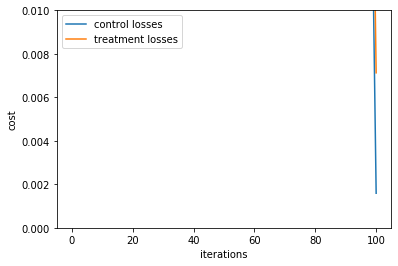

In [289]:
plt.figure()
plt.plot([100*i for i in range(len(testExp.control_losses))],testExp.control_losses,label='control losses')
plt.plot([100*i for i in range(len(testExp.control_losses))],testExp.treatment_losses,label='treatment losses')
plt.xlabel('iterations')
plt.ylabel('cost')
plt.ylim(0,10**-2)
plt.legend()

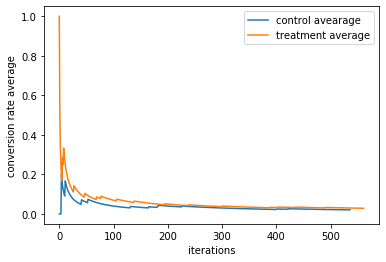

In [281]:
def moving_average(array,window_length=1):
    x=[array[0]]*len(array)
    loop_num=1
    for i,item in enumerate(x[1:]):
            x[i]=(x[i-1]+array[i+1])
    for i,item in enumerate(x):
        x[i]=x[i]/(i+1)
    return x[:-1]
    
base_ma=moving_average(testExp.base_events)
conversion_ma=moving_average(testExp.treatment_events)

plt.figure()
plt.plot([i for i in range(len(base_ma))],base_ma,label='control avearage')
plt.plot([i for i in range(len(conversion_ma))],conversion_ma,label='treatment average')
plt.xlabel('iterations')
plt.ylabel('conversion rate average')
plt.legend()